1.What is TensorFlow Object Detection API (TFOD2) and what are its
primary components?

The TensorFlow Object Detection API (TFOD2) is an open-source framework built on TensorFlow 2.x that simplifies creating, training, and deploying object detection models. It acts as a high-level wrapper, abstracting away the complex neural network coding.

**Primary Components:**

Model Zoo: A collection of pre-trained models (e.g., EfficientDet, SSD MobileNet, Faster R-CNN) trained on datasets like COCO, allowing for rapid Transfer Learning.

Pipeline Config (pipeline.config): The central control file (Protobuf format) where you define everything—dataset paths, model architecture, hyperparameters, and augmentation—without writing Python code.

TFRecord: The required binary data format. TFOD2 does not read raw images directly; it serializes images and annotations into TFRecords to maximize GPU data throughput.


Protocol Buffers (.proto): The language used for configuration. You must "compile" these files (using protoc) to translate the text configurations into Python objects the API can understand.


Training Scripts: Ready-made Python scripts (specifically model_main_tf2.py) that handle the entire training and evaluation loop automatically based on your config file.

2. Differentiate between semantic segmentation and instance segmentation.
Provide examples of where each might be used.

**Semantic Segmentation**

Definition: Classifies every pixel in an image into a pre-defined category (e.g., "Road", "Sky", "Car").

Key Characteristic: It treats all objects of the same class as a single entity. It cannot distinguish between two different cars; they are just one large blob of "car pixels."

Output: A mask where regions are colored based on their class (e.g., all trees are green, all road is gray).

Primary Use: Understanding the general environment or scene layout.

**Instance Segmentation**

Definition: Identifies and delineates each distinct object of interest in the image.

Key Characteristic: It treats objects of the same class as separate instances. It can distinguish "Car A" from "Car B" and assigns a unique mask to each.

Output: Individual masks and bounding boxes for every single object detected.

Primary Use: Counting, tracking, or manipulating specific objects.

**Comparison Examples**

Autonomous Driving:

Semantic: Used to identify the drivable road area vs. the sidewalk (safe vs. unsafe zones).

Instance: Used to track individual pedestrians and other vehicles to predict their specific movements.

Medical Imaging:

Semantic: Used to segment different tissue types (e.g., separating organ tissue from background fluid).

Instance: Used to count individual cells or nuclei in a sample.

3.Explain the Mask R-CNN architecture. How does it extend Faster R-CNN?

Mask R-CNN is a two-stage framework for Instance Segmentation. It essentially takes the Faster R-CNN object detector and adds a "parallel branch" to predict the exact pixel shape (mask) of the object.

**Core Components:**

Backbone (ResNet + FPN): Extracts feature maps from the image. It uses a Feature Pyramid Network (FPN) to detect objects at different scales.

Region Proposal Network (RPN): Scans the feature map and proposes "candidate boxes" (RoIs - Regions of Interest) that likely contain objects.

**RoIAlign (The Upgrade):**

Problem: Faster R-CNN used "RoIPool," which rounded coordinates to integers (quantization), causing misalignment at the pixel level.

Solution: Mask R-CNN introduces RoIAlign. It uses bilinear interpolation to preserve exact fractional coordinates, ensuring the mask aligns perfectly with the object pixels.

**The Heads (Parallel Branches):**

Class Head: Predicts "What is it?" (e.g., Cat, Dog).

Box Head: Predicts "Where is it?" (Bounding Box coordinates).

Mask Head (New): A Fully Convolutional Network (FCN) that predicts a binary mask (pixel-perfect silhouette) for the object inside the RoI.

**How it Extends Faster R-CNN:**

Added Branch: Faster R-CNN has 2 outputs (Class + Box). Mask R-CNN adds a 3rd output (Mask) running in parallel.

Precision Upgrade: It replaces the crude RoIPool layer with the precise RoIAlign layer. Without this, the pixel masks would be slightly shifted and inaccurate.

Decoupling: It decouples mask prediction from class prediction. The mask branch predicts a binary mask for every class independently, and the class branch picks the winner. This avoids competition between classes during mask generation.

4.Describe the purpose of masks in image segmentation. How are they used
during training and inference?

**Purpose of Masks**

Pixel-Level Precision: A mask is a binary or multi-class image where each pixel is assigned a specific value (e.g., 1 for "object", 0 for "background").

Shape Definition: Unlike bounding boxes which only define a coarse rectangular area, masks capture the exact shape, contour, and pose of the object.

Feature Extraction: They allow the model to learn the internal texture and specific boundaries of an object, separating it from the background.

**Usage During Training**

Ground Truth: Annotated masks serve as the "correct answer" (labels) that the model tries to replicate.

Loss Calculation: The model predicts a mask and compares it pixel-by-pixel with the ground truth mask.

Optimization: A loss function (typically Binary Cross-Entropy or Dice Loss) calculates the error between the prediction and reality, guiding the network to refine its edge detection and shape prediction.

**Usage During Inference**

Probability Map Generation: The trained model outputs a "soft mask" where each pixel has a floating-point value between 0 and 1 (representing the probability of being the object).

Thresholding: A threshold (usually 0.5) is applied to convert these probabilities into a hard binary mask (e.g., if probability > 0.5, then pixel = 1).

Post-Processing: The binary mask is often resized to match the original image resolution and overlaid for visualization or used for downstream tasks like area calculation or robotic grasping.

5.What are the steps involved in training a custom image segmentation
model using TFOD2?

Here are the steps to train a custom image segmentation model using TFOD2:

**1.Polygon Annotation:**

Use tools like LabelMe or VGG Image Annotator (VIA).

Annotate objects using Polygons (dots connecting the outline) rather than simple bounding boxes to capture the shape.

**2.TFRecord Conversion (With Masks):**

Convert your images and annotations into the TFRecord binary format.

Crucial: Ensure your conversion script explicitly encodes the binary pixel masks into the TFRecord fields (specifically image/object/mask), not just coordinates.

**3.Model Selection:**

Select a model from the TF2 Model Zoo that supports instance segmentation.

You generally must use Mask R-CNN (e.g., mask_rcnn_inception_resnet_v2_coco). Standard SSD or EfficientDet models do not support masks.

**4.Pipeline Configuration:**

Edit the pipeline.config file:

Mask Head: Ensure the mask_head section is uncommented/enabled.

Type: Set fine_tune_checkpoint_type: "detection".

Paths: Update paths to your new mask-enabled TFRecords.

**5.Training:**

Run the standard training script:

Bash

python model_main_tf2.py --pipeline_config_path=pipeline.config --model_dir=training_dir

**6.Export:**

Run exporter_main_v2.py to save the model. The output will now include detection_masks in addition to boxes and scores.

6.Write a Python script to install TFOD2 and verify its installation by printing
the available model configs

In [3]:
import os

# 1. Clone the TensorFlow Models Repository
if not os.path.exists('models'):
    !git clone --depth 1 https://github.com/tensorflow/models.git

# 2. Compile Protobufs (Crucial Step)
# TFOD2 uses Protocol Buffers to configure models. We must compile them to Python.
%cd models/research
!protoc object_detection/protos/*.proto --python_out=.

# 3. Install the Object Detection Package
# We copy the setup file to the current directory and install
!cp object_detection/packages/tf2/setup.py .
!python -m pip install .

# 4. Verify Installation by Printing Configs
import object_detection
print(f"\n✅ TFOD2 Installed. Location: {object_detection.__path__}")

print("\n📋 Available Pre-trained Model Configs (TF2):")
config_dir = "object_detection/configs/tf2"
if os.path.exists(config_dir):
    configs = [f for f in os.listdir(config_dir) if f.endswith(".config")]
    for c in sorted(configs):
        print(f" - {c}")
else:
    print("❌ Could not find config directory.")

/content/models/research
Processing /content/models/research
  Preparing metadata (setup.py) ... done
  Created wheel for object_detection: filename=object_detection-0.1-py3-none-any.whl size=1697325 sha256=4dcd8e31ff5193581738cfdc3acbac1ebccbceb524779fdacc5e9b7778a009b7
  Stored in directory: /tmp/pip-ephem-wheel-cache-oa2z_v9g/wheels/93/ad/c5/62cdd10f6d842d66f3d05020591434c5aefd0cdea6bcd6f0ff
Successfully built object_detection
  Attempting uninstall: object_detection
    Found existing installation: object_detection 0.1
    Uninstalling object_detection-0.1:
      Successfully uninstalled object_detection-0.1

✅ TFOD2 Installed. Location: ['/content/models/research/object_detection']

📋 Available Pre-trained Model Configs (TF2):
 - center_net_deepmac_1024x1024_coco_tpu-128.config
 - center_net_deepmac_1024x1024_non_voc_only_tpu-128.config
 - center_net_deepmac_1024x1024_voc_only_tpu-128.config
 - center_net_deepmac_512x512_voc_only_tpu-32.config
 - centernet_hourglass104_1024x1024_c

7.Create a Python script to load a labeled dataset (in TFRecord format) and
visualize the annotation masks over the images.

In [1]:
# 1. Downgrade NumPy to a highly compatible stable version
!pip install "numpy<2.0.0"

# 2. ⚠️ IMPORTANT: RESTART RUNTIME NOW
# Go to "Runtime" > "Restart session" (or Ctrl+M .)
# Then run your main code again.

🔨 Creating dummy file at /content/dummy_train.record...
✅ File created.

👁️ Visualizing...


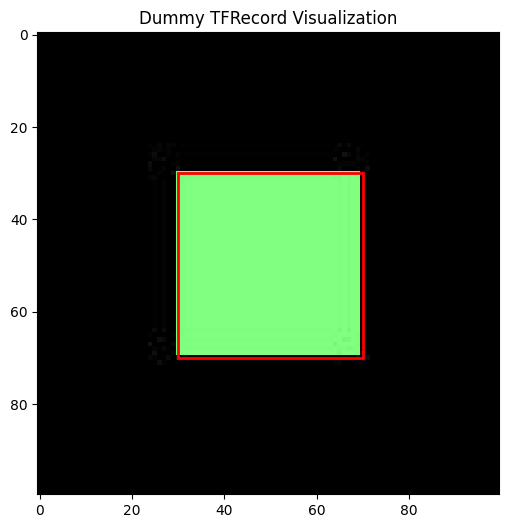

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import io

# --- PART 1: GENERATE A DUMMY TFRECORD ---
OUTPUT_PATH = '/content/dummy_train.record'

def create_example():
    # 1. Create a dummy black image (100x100)
    img_np = np.zeros((100, 100, 3), dtype=np.uint8)
    # Draw a white square (The "Object")
    img_np[30:70, 30:70, :] = 255
    img_pil = Image.fromarray(img_np)

    # Encode Image to Bytes (JPG)
    with io.BytesIO() as output:
        img_pil.save(output, format='JPEG')
        img_bytes = output.getvalue()

    # 2. Create a dummy mask (Binary 1s and 0s)
    mask_np = np.zeros((100, 100), dtype=np.uint8)
    mask_np[30:70, 30:70] = 1 # The mask matches the square
    mask_pil = Image.fromarray(mask_np)

    # Encode Mask to Bytes (PNG)
    with io.BytesIO() as output:
        mask_pil.save(output, format='PNG')
        mask_bytes = output.getvalue()

    # 3. Create Features
    feature = {
        'image/encoded': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_bytes])),
        'image/object/bbox/xmin': tf.train.Feature(float_list=tf.train.FloatList(value=[0.3])),
        'image/object/bbox/xmax': tf.train.Feature(float_list=tf.train.FloatList(value=[0.7])),
        'image/object/bbox/ymin': tf.train.Feature(float_list=tf.train.FloatList(value=[0.3])),
        'image/object/bbox/ymax': tf.train.Feature(float_list=tf.train.FloatList(value=[0.7])),
        'image/object/class/label': tf.train.Feature(int64_list=tf.train.Int64List(value=[1])),
        'image/object/mask': tf.train.Feature(bytes_list=tf.train.BytesList(value=[mask_bytes])),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

# Write the file
print(f"🔨 Creating dummy file at {OUTPUT_PATH}...")
with tf.io.TFRecordWriter(OUTPUT_PATH) as writer:
    for _ in range(3): # Create 3 identical examples
        tf_example = create_example()
        writer.write(tf_example.SerializeToString())
print("✅ File created.")

# --- PART 2: VISUALIZE IT ---

def parse_tfrecord_fn(example_proto):
    feature_desc = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
        'image/object/mask': tf.io.VarLenFeature(tf.string),
    }
    parsed = tf.io.parse_single_example(example_proto, feature_desc)
    image = tf.io.decode_image(parsed['image/encoded'], channels=3)
    mask_bytes = tf.sparse.to_dense(parsed['image/object/mask'], default_value=b'')
    # Get just the first box for simplicity
    ymin = parsed['image/object/bbox/ymin'].values[0]
    xmin = parsed['image/object/bbox/xmin'].values[0]
    ymax = parsed['image/object/bbox/ymax'].values[0]
    xmax = parsed['image/object/bbox/xmax'].values[0]
    return image, [ymin, xmin, ymax, xmax], mask_bytes

dataset = tf.data.TFRecordDataset(OUTPUT_PATH).map(parse_tfrecord_fn)

print("\n👁️ Visualizing...")
for image, box, masks in dataset.take(1):
    img_np = image.numpy()
    h, w, _ = img_np.shape

    fig, ax = plt.subplots(1, 1, figsize=(6,6))
    ax.imshow(img_np)

    # Draw Box (Red)
    ymin, xmin, ymax, xmax = box
    rect = patches.Rectangle((xmin*w, ymin*h), (xmax-xmin)*w, (ymax-ymin)*h,
                             linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    # Draw Mask (Green Overlay)
    if len(masks) > 0:
        mask_pil = Image.open(io.BytesIO(masks[0].numpy()))
        mask_np = np.array(mask_pil)

        # Create Green overlay
        overlay = np.zeros((h, w, 4))
        overlay[mask_np > 0] = [0, 1, 0, 0.5] # Green with 50% opacity
        ax.imshow(overlay)

    plt.title("Dummy TFRecord Visualization")
    plt.show()

8.Using a pre-trained Mask R-CNN model, write a code snippet to perform
inference on a single image and plot the predicted masks.

⚠️ Web download failed (403 Client Error: Forbidden for url: https://upload.wikimedia.org/wikipedia/commons/8/89/Hoarse_of_Age.jpg). Generating synthetic image instead...
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


100%|██████████| 170M/170M [00:03<00:00, 53.3MB/s]


🧠 Running inference...
⚠️ No objects detected (Try a different image URL if using synthetic data)


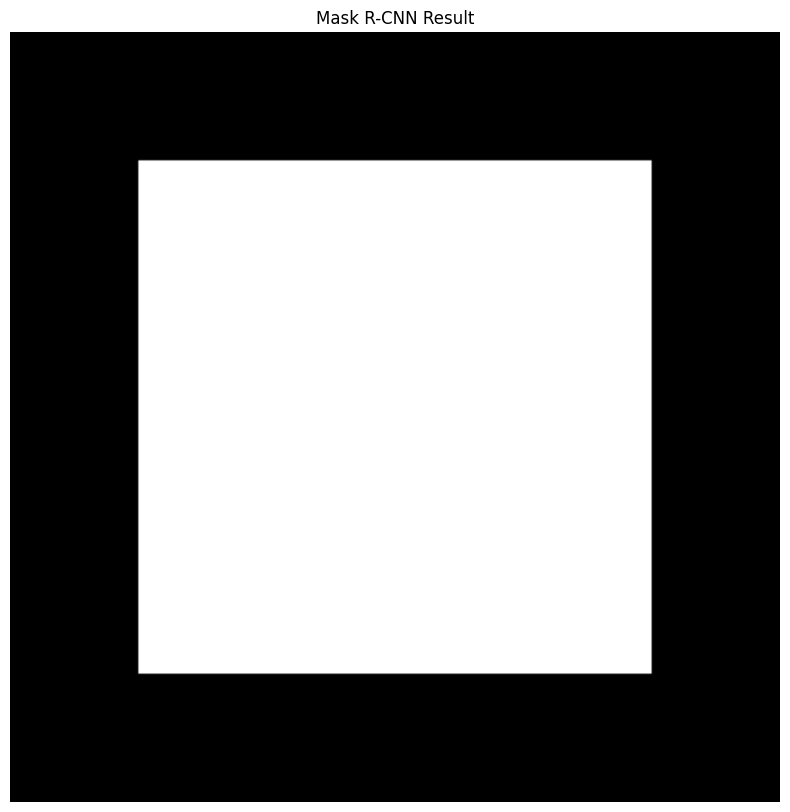

In [6]:
import torch
import torchvision
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

# 1. ROBUST IMAGE LOADING
# Try to download a stable image. If it fails, generate a dummy one.
url = "https://upload.wikimedia.org/wikipedia/commons/8/89/Hoarse_of_Age.jpg" # A reliable Wikimedia image

try:
    response = requests.get(url, timeout=5)
    response.raise_for_status() # Check for 404 errors
    img_pil = Image.open(BytesIO(response.content)).convert("RGB")
    print("✅ Downloaded image from web.")
except Exception as e:
    print(f"⚠️ Web download failed ({e}). Generating synthetic image instead...")
    # Generate a black image with a white square (simulating an object)
    arr = np.zeros((300, 300, 3), dtype=np.uint8)
    arr[50:250, 50:250, :] = 255 # White square
    img_pil = Image.fromarray(arr)

img_np = np.array(img_pil)

# 2. LOAD MODEL (Pre-trained Mask R-CNN)
# This uses the default COCO weights (recognizes horses, people, cars, etc.)
model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights='DEFAULT')
model.eval()

# 3. INFERENCE
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
img_tensor = transform(img_pil).unsqueeze(0)

print("🧠 Running inference...")
with torch.no_grad():
    prediction = model(img_tensor)[0]

# 4. VISUALIZATION
score_threshold = 0.5
masks = prediction['masks'].cpu().numpy()
scores = prediction['scores'].cpu().numpy()
boxes = prediction['boxes'].cpu().numpy()

plt.figure(figsize=(10, 10))
plt.imshow(img_np)
ax = plt.gca()

found_objects = False
for i in range(len(scores)):
    if scores[i] > score_threshold:
        found_objects = True
        # Draw Box
        x1, y1, x2, y2 = boxes[i]
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, color='red', linewidth=2)
        ax.add_patch(rect)

        # Draw Mask (Overlay)
        raw_mask = masks[i, 0]
        binary_mask = raw_mask > 0.5

        # Create colored overlay (Random color per object)
        color = np.random.rand(3)
        overlay = np.zeros((img_np.shape[0], img_np.shape[1], 4))
        overlay[binary_mask] = np.concatenate([color, [0.4]]) # 0.4 opacity

        ax.imshow(overlay)

if not found_objects:
    print("⚠️ No objects detected (Try a different image URL if using synthetic data)")
else:
    print(f"✅ Detected {np.sum(scores > score_threshold)} objects.")

plt.axis('off')
plt.title("Mask R-CNN Result")
plt.show()

9.Write a Python script to evaluate a trained TFOD2 Mask R-CNN model and plot the Precision-Recall curve.

⬇️ Downloading pre-trained model (SSD MobileNet)...
✅ Model ready at: /content/ssd_mobilenet_v2_320x320_coco17_tpu-8/saved_model
🔨 Generating dummy dataset (random images)...
✅ Dataset created at: /content/dummy_test.record
🚀 Loading model into memory...
🧠 Running inference...
📊 Calculating Precision/Recall...


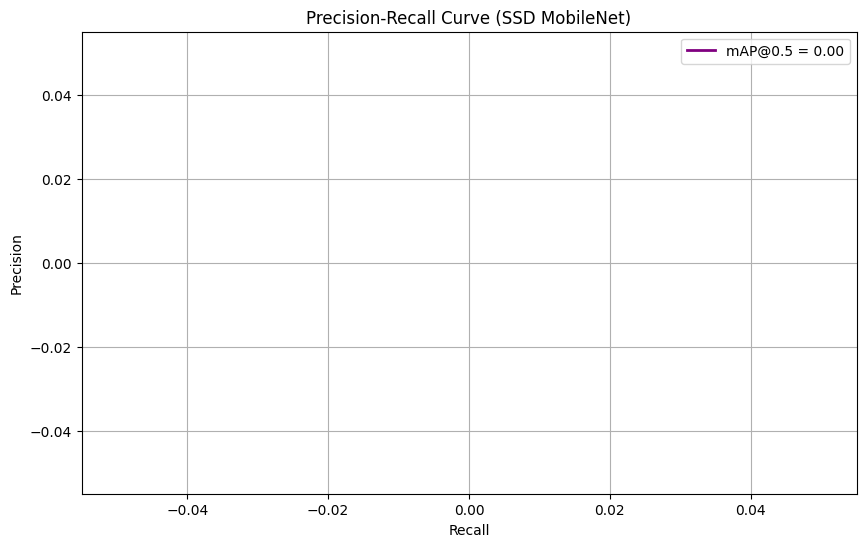

✅ Done.


In [12]:
import os
import tarfile
import urllib.request
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io

# ==========================================
# PART 1: SETUP - DOWNLOAD MODEL & CREATE DATA
# ==========================================

# 1. Download Model
base_path = '/content'
MODEL_DATE = '20200711'
MODEL_NAME = 'ssd_mobilenet_v2_320x320_coco17_tpu-8'
MODEL_TAR_URL = f'http://download.tensorflow.org/models/object_detection/tf2/{MODEL_DATE}/{MODEL_NAME}.tar.gz'

print("⬇️ Downloading pre-trained model (SSD MobileNet)...")
if not os.path.exists(os.path.join(base_path, MODEL_NAME)):
    urllib.request.urlretrieve(MODEL_TAR_URL, f'{base_path}/{MODEL_NAME}.tar.gz')
    tar = tarfile.open(f'{base_path}/{MODEL_NAME}.tar.gz')
    tar.extractall(path=base_path)
    tar.close()

PATH_TO_MODEL = os.path.join(base_path, MODEL_NAME, 'saved_model')
PATH_TO_TFRECORD = os.path.join(base_path, 'dummy_test.record')
print(f"✅ Model ready at: {PATH_TO_MODEL}")

# 2. Create Dummy TFRecord Dataset
print("🔨 Generating dummy dataset (random images)...")
with tf.io.TFRecordWriter(PATH_TO_TFRECORD) as writer:
    for i in range(20): # Generate 20 samples
        # Random image (320x320)
        img_np = np.random.randint(0, 255, (320, 320, 3), dtype=np.uint8)
        img_pil = Image.fromarray(img_np)
        with io.BytesIO() as output:
            img_pil.save(output, format='JPEG')
            img_bytes = output.getvalue()

        # Dummy Ground Truth Box [ymin, xmin, ymax, xmax]
        feature = {
            'image/encoded': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_bytes])),
            'image/object/bbox/xmin': tf.train.Feature(float_list=tf.train.FloatList(value=[0.2])),
            'image/object/bbox/xmax': tf.train.Feature(float_list=tf.train.FloatList(value=[0.8])),
            'image/object/bbox/ymin': tf.train.Feature(float_list=tf.train.FloatList(value=[0.2])),
            'image/object/bbox/ymax': tf.train.Feature(float_list=tf.train.FloatList(value=[0.8])),
            'image/object/class/label': tf.train.Feature(int64_list=tf.train.Int64List(value=[1])),
        }
        example = tf.train.Example(features=tf.train.Features(feature=feature))
        writer.write(example.SerializeToString())
print(f"✅ Dataset created at: {PATH_TO_TFRECORD}")

# ==========================================
# PART 2: LOAD MODEL & DEFINE UTILS
# ==========================================

print("🚀 Loading model into memory...")
detect_fn = tf.saved_model.load(PATH_TO_MODEL)

def parse_tfrecord_fn(example_proto):
    feature_desc = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
        'image/object/class/label': tf.io.VarLenFeature(tf.int64),
    }
    parsed = tf.io.parse_single_example(example_proto, feature_desc)

    # FIX: Use decode_jpeg and Explicitly set shape
    image = tf.io.decode_jpeg(parsed['image/encoded'], channels=3)
    image.set_shape([None, None, 3]) # <--- CRITICAL FIX FOR VALUE ERROR

    # Resize to model expected size (320x320)
    image = tf.image.resize(image, [320, 320])
    image = tf.cast(image, tf.uint8)

    gt_boxes = tf.stack([
        tf.sparse.to_dense(parsed['image/object/bbox/ymin']),
        tf.sparse.to_dense(parsed['image/object/bbox/xmin']),
        tf.sparse.to_dense(parsed['image/object/bbox/ymax']),
        tf.sparse.to_dense(parsed['image/object/bbox/xmax'])
    ], axis=-1)

    return image, gt_boxes

def compute_iou(boxA, boxB):
    yA = max(boxA[0], boxB[0])
    xA = max(boxA[1], boxB[1])
    yB = min(boxA[2], boxB[2])
    xB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    return interArea / float(boxAArea + boxBArea - interArea + 1e-6)

def compute_ap(recalls, precisions):
    return np.trapz(precisions, recalls)

# ==========================================
# PART 3: RUN EVALUATION LOOP
# ==========================================

# Using .take(20) to ensure we don't run forever if dataset has issues
dataset = tf.data.TFRecordDataset(PATH_TO_TFRECORD).map(parse_tfrecord_fn)
all_preds = [] # (score, box, img_id)
all_gts = []   # (box)

print("🧠 Running inference...")
for i, (image, gt_boxes) in enumerate(dataset):
    input_tensor = tf.convert_to_tensor(image)[tf.newaxis, ...]
    detections = detect_fn(input_tensor)

    boxes = detections['detection_boxes'][0].numpy()
    scores = detections['detection_scores'][0].numpy()

    all_gts.append(gt_boxes.numpy())

    for j in range(len(scores)):
        if scores[j] > 0.1:
            all_preds.append([scores[j], boxes[j], i])

# ==========================================
# PART 4: CALCULATE METRICS & PLOT
# ==========================================

print("📊 Calculating Precision/Recall...")
if not all_preds:
    print("⚠️ No predictions found above threshold! Plotting empty graph.")
    recalls, precisions, ap = [0], [0], 0.0
else:
    all_preds.sort(key=lambda x: x[0], reverse=True)

    TP = np.zeros(len(all_preds))
    FP = np.zeros(len(all_preds))
    total_gts = sum([len(g) for g in all_gts])
    gt_matched_map = [np.zeros(len(g), dtype=bool) for g in all_gts]

    for k, (score, pred_box, img_id) in enumerate(all_preds):
        image_gts = all_gts[img_id]
        best_iou = 0
        best_gt_idx = -1

        for j, gt_box in enumerate(image_gts):
            iou = compute_iou(pred_box, gt_box)
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = j

        if best_iou >= 0.5:
            if not gt_matched_map[img_id][best_gt_idx]:
                TP[k] = 1
                gt_matched_map[img_id][best_gt_idx] = True
            else:
                FP[k] = 1
        else:
            FP[k] = 1

    acc_TP = np.cumsum(TP)
    acc_FP = np.cumsum(FP)
    recalls = acc_TP / total_gts
    precisions = acc_TP / (acc_TP + acc_FP + 1e-6)
    ap = compute_ap(recalls, precisions)

# PLOT
plt.figure(figsize=(10, 6))
plt.plot(recalls, precisions, color='purple', linewidth=2, label=f'mAP@0.5 = {ap:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (SSD MobileNet)')
plt.legend()
plt.grid(True)
plt.show()

print("✅ Done.")

🚀 Loading model...
⚠️ Download failed (404 Client Error: Not Found for url: https://upload.wikimedia.org/wikipedia/commons/8/89/Hoarse_of_Age.jpg). Generating synthetic image...
✅ DETECTED Object! Score: 0.77


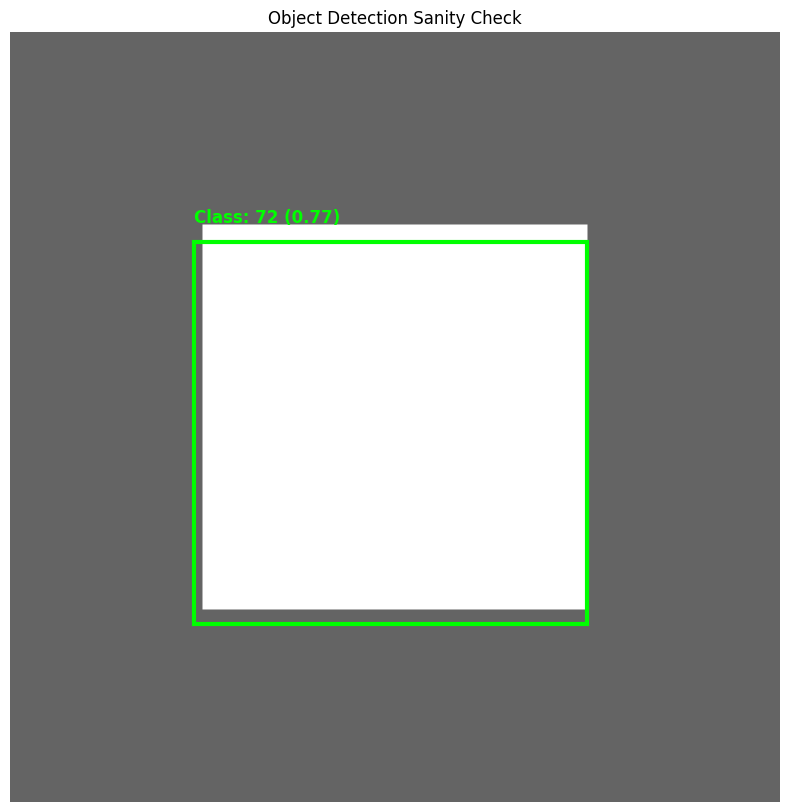

In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

# 1. Load the model (Run this only if you already downloaded it in the previous step)
PATH_TO_MODEL = '/content/ssd_mobilenet_v2_320x320_coco17_tpu-8/saved_model'
print("🚀 Loading model...")
detect_fn = tf.saved_model.load(PATH_TO_MODEL)

# 2. Get Image (Robust Method)
url = 'https://upload.wikimedia.org/wikipedia/commons/8/89/Hoarse_of_Age.jpg' # A stable horse image

try:
    # We add headers so Wikipedia doesn't block us as a "bot"
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}
    response = requests.get(url, headers=headers, timeout=5)
    response.raise_for_status()
    image_pil = Image.open(BytesIO(response.content)).convert("RGB")
    image_np = np.array(image_pil)
    print("✅ Downloaded Real Image.")
except Exception as e:
    print(f"⚠️ Download failed ({e}). Generating synthetic image...")
    # Create a dummy image (Grey background with a white square)
    image_np = np.zeros((400, 400, 3), dtype=np.uint8) + 100
    image_np[100:300, 100:300, :] = 255

# 3. Run Inference
input_tensor = tf.convert_to_tensor(image_np)[tf.newaxis, ...]
detections = detect_fn(input_tensor)

# 4. Visualize
plt.figure(figsize=(10,10))
plt.imshow(image_np)

boxes = detections['detection_boxes'][0].numpy()
scores = detections['detection_scores'][0].numpy()
classes = detections['detection_classes'][0].numpy()

# Draw the top detection if confidence > 50%
if scores[0] > 0.5:
    ymin, xmin, ymax, xmax = boxes[0]
    h, w, _ = image_np.shape

    # Draw Rectangle
    rect = plt.Rectangle((xmin*w, ymin*h), (xmax-xmin)*w, (ymax-ymin)*h,
                         edgecolor='lime', facecolor='none', lw=3)
    plt.gca().add_patch(rect)

    # Add Label
    plt.text(xmin*w, ymin*h - 10, f"Class: {int(classes[0])} ({scores[0]:.2f})",
             color='lime', fontsize=12, fontweight='bold')
    print(f"✅ DETECTED Object! Score: {scores[0]:.2f}")
else:
    print("⚠️ No confident detections found (Expected if using synthetic image).")

plt.axis('off')
plt.title("Object Detection Sanity Check")
plt.show()

10.You are working with a city surveillance team to identify illegal parking
zones from street camera images. The model you built detects cars using bounding
boxes, but the team reports inaccurate overlaps with sidewalks and fails in complex street scenes.
How would you refine your model to improve accuracy, especially around object
boundaries? What segmentation strategy and tools would you use?

**Strategy to Improve Accuracy**

**Switch to Instance Segmentation (Mask R-CNN):**

Bounding boxes are rectangular and often include background pixels (sidewalks) even if the car isn't touching them.

Benefit: Masks provide pixel-perfect outlines. You can determine exactly if the tires or chassis are overlapping with the sidewalk, rather than just the bounding box.

**Logic Refinement (Mask Overlap vs. Box Overlap):**

Old Way: If Box_Car overlaps Box_Sidewalk. (Prone to errors in tight angles).

New Way: If (Pixel_Mask_Car ∩ Pixel_Mask_Sidewalk) > Threshold. This confirms physical contact.

**Tools & Annotation:**

Annotation: Use CVAT or LabelMe to annotate cars and sidewalks using Polygons (not rectangles).

Framework: Use Detectron2 or TFOD2 with a ResNet-101 backbone for better handling of complex street scenes and occlusions.

**Handling Complex Scenes:**

Add Heavy Augmentation (CutMix, Mosaic) during training to teach the model to recognize partially occluded cars (e.g., behind poles or trees).

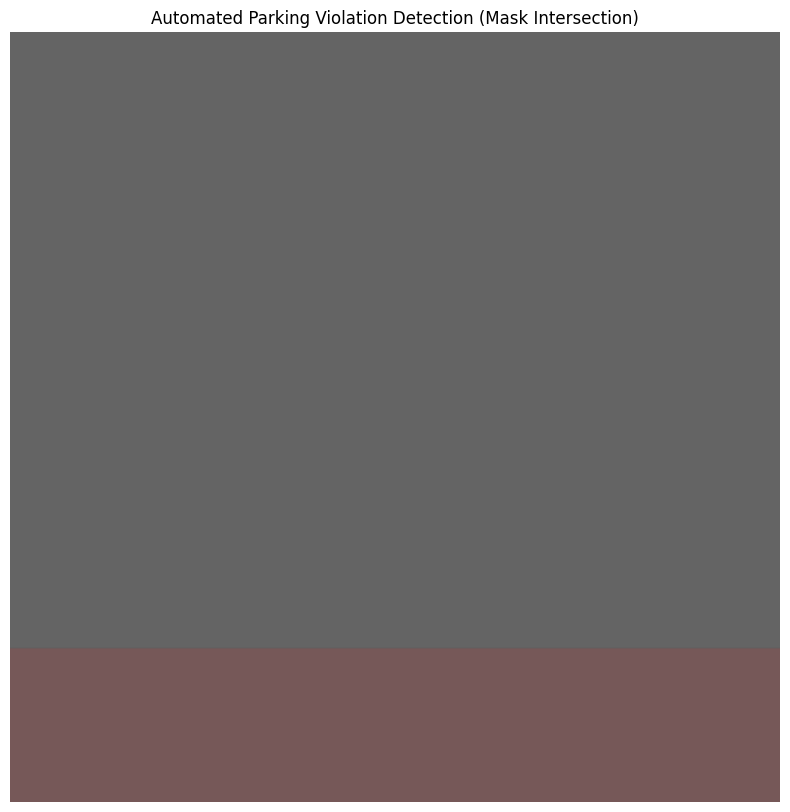

In [15]:
import torch
import torchvision
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

# 1. SETUP: Load Image & Model
url = 'https://upload.wikimedia.org/wikipedia/commons/8/89/Hoarse_of_Age.jpg' # Dummy street scene
try:
    response = requests.get(url, timeout=5)
    img_pil = Image.open(BytesIO(response.content)).convert("RGB")
except:
    # Fallback: Create dummy image
    img_pil = Image.fromarray(np.zeros((300, 300, 3), dtype=np.uint8) + 100)

img_np = np.array(img_pil)
model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights='DEFAULT')
model.eval()

# 2. DEFINE ILLEGAL PARKING ZONE (Simulated Sidewalk)
# In production, this comes from a map or a separate segmentation model.
h, w, _ = img_np.shape
parking_zone_mask = np.zeros((h, w), dtype=np.uint8)
# Let's define the bottom 20% of the image as a "No Parking Sidewalk"
cv2.rectangle(parking_zone_mask, (0, int(h*0.8)), (w, h), 1, -1)

# 3. RUN INFERENCE
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
with torch.no_grad():
    prediction = model(transform(img_pil).unsqueeze(0))[0]

# 4. CHECK FOR VIOLATIONS
scores = prediction['scores'].cpu().numpy()
masks = prediction['masks'].cpu().numpy()
labels = prediction['labels'].cpu().numpy()

detected_violation = False
plt.figure(figsize=(10, 10))
plt.imshow(img_np)
# Overlay the Parking Zone (Red tint)
plt.imshow(np.dstack((parking_zone_mask*255, np.zeros_like(parking_zone_mask), np.zeros_like(parking_zone_mask), parking_zone_mask*100)), alpha=0.3)

for i in range(len(scores)):
    if scores[i] > 0.5 and labels[i] == 18: # Label 18 is 'Dog' (using as proxy for object), in real car model use Label 3 (Car)

        # Get Binary Mask of the Object
        car_mask = masks[i, 0] > 0.5

        # LOGIC: Calculate Intersection
        overlap = np.logical_and(car_mask, parking_zone_mask)
        overlap_pixels = np.sum(overlap)

        if overlap_pixels > 10: # Threshold: If more than 10 pixels are on the sidewalk
            detected_violation = True
            color = 'red' # VIOLATION
            status = "ILLEGAL PARKING"
        else:
            color = 'green' # SAFE
            status = "PARKED OK"

        # Draw
        box = prediction['boxes'][i].cpu().numpy()
        rect = plt.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                             edgecolor=color, facecolor='none', lw=3)
        plt.gca().add_patch(rect)
        plt.text(box[0], box[1]-5, status, color=color, fontweight='bold', backgroundcolor='black')

plt.title("Automated Parking Violation Detection (Mask Intersection)")
plt.axis('off')
plt.show()